In [1]:
import pandas as pd
import numpy as np
import pyodbc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pickle
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configuration
DATA_DIR = Path("analysis_data")
CHECKPOINT_DIR = DATA_DIR / "checkpoints"
DATA_DIR.mkdir(exist_ok=True)
CHECKPOINT_DIR.mkdir(exist_ok=True)

In [2]:
import pandas as pd
import numpy as np
import pyodbc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pickle
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configuration
DATA_DIR = Path("analysis_data")
CHECKPOINT_DIR = DATA_DIR / "checkpoints"
DATA_DIR.mkdir(exist_ok=True)
CHECKPOINT_DIR.mkdir(exist_ok=True)

class CheckpointManager:
    def __init__(self, process_name, parameters=None):
        self.process_name = process_name
        self.parameters = parameters or {}
        # Create unique checkpoint file based on parameters
        param_hash = hash(str(sorted(self.parameters.items())))
        self.checkpoint_file = CHECKPOINT_DIR / f"{process_name}_{param_hash}_progress.json"
        self.progress = self.load_progress()
    
    def load_progress(self):
        if self.checkpoint_file.exists():
            with open(self.checkpoint_file, 'r') as f:
                data = json.load(f)
                # Verify parameters match
                if data.get("parameters") == self.parameters:
                    return data
                else:
                    print(f"Parameters changed for {self.process_name}, starting fresh")
                    return self._create_new_progress()
        return self._create_new_progress()
    
    def _create_new_progress(self):
        return {
            "parameters": self.parameters,
            "completed_chunks": [], 
            "status": "not_started", 
            "last_chunk": -1
        }
    
    def save_progress(self, chunk_info):
        self.progress["completed_chunks"].append(chunk_info)
        self.progress["last_chunk"] = len(self.progress["completed_chunks"]) - 1
        self.progress["status"] = "in_progress"
        self.progress["parameters"] = self.parameters
        with open(self.checkpoint_file, 'w') as f:
            json.dump(self.progress, f, indent=2)
    
    def mark_completed(self):
        self.progress["status"] = "completed"
        self.progress["parameters"] = self.parameters
        with open(self.checkpoint_file, 'w') as f:
            json.dump(self.progress, f, indent=2)
    
    def is_chunk_completed(self, chunk_id):
        return any(chunk["chunk_id"] == chunk_id for chunk in self.progress["completed_chunks"])
    
    def get_completed_chunks(self):
        return [chunk["filename"] for chunk in self.progress["completed_chunks"]]

def save_dataframe(df, filename_base):
    """Save dataframe with best available format"""
    try:
        # Try parquet first
        parquet_file = DATA_DIR / f"{filename_base}.parquet"
        df.to_parquet(parquet_file, index=False)
        return parquet_file
    except ImportError:
        # Fallback to pickle
        pickle_file = DATA_DIR / f"{filename_base}.pkl"
        with open(pickle_file, 'wb') as f:
            pickle.dump(df, f)
        return pickle_file

def load_dataframe(filename_base):
    """Load dataframe from best available format"""
    for ext, loader in [('.parquet', pd.read_parquet), ('.pkl', lambda x: pickle.load(open(x, 'rb')))]:
        file_path = DATA_DIR / f"{filename_base}{ext}"
        if file_path.exists():
            return loader(file_path)
    return None

def connect_server(ip, database):
    conn_str = (
        "Driver={SQL Server};"
        "Server=" + ip + ";" + 
        "Database=" + database + ";" + 
        "Trusted_Connection=yes;"
    )
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()
    return conn, cursor

def sql_to_pandas(conn, cursor, sql_string):
    cursor.execute(sql_string)
    rows = cursor.fetchall()
    if rows:
        return pd.DataFrame.from_records(rows, columns=[desc[0] for desc in cursor.description])
    return pd.DataFrame()

def close_conn(conn, cursor):
    cursor.close()
    conn.close()


In [3]:

def load_facts_with_checkpoints(chunk_days=7, start_date='2025-01-01', end_date='2025-12-31', test_mode=False):
    """
    Load facts data with loyalty.cards join and checkpoint system - never lose progress
    NOW USING CUSTOMER_ID INSTEAD OF DISCOUNT_CARD_NO
    """
    # Create unique checkpoint based on parameters
    params = {
        'chunk_days': chunk_days,
        'start_date': start_date, 
        'end_date': end_date,
        'test_mode': test_mode
    }
    checkpoint_mgr = CheckpointManager("facts_loading_with_customer_id", params)
    
    # Create unique filename for this configuration
    if test_mode:
        combined_filename = "facts_data_test_combined_customer_id"
        print("TEST MODE: Loading only 1 week of data for testing...")
        end_date = '2025-01-07'
        chunk_days = 7
    else:
        combined_filename = "facts_data_2025_combined_customer_id"
    
    print(f"Loading facts data with customer_id from {start_date} to {end_date}")
    
    # Check if we already completed this specific configuration
    if checkpoint_mgr.progress["status"] == "completed":
        print("Facts data with customer_id already fully loaded for these parameters! Loading combined file...")
        return load_dataframe(combined_filename)
    
    # Generate date chunks
    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_chunks = []
    current_date = start_dt
    chunk_id = 0
    while current_date <= end_dt:
        chunk_end = min(current_date + timedelta(days=chunk_days), end_dt)
        date_chunks.append({
            "chunk_id": chunk_id,
            "start": current_date.strftime('%Y-%m-%d'), 
            "end": chunk_end.strftime('%Y-%m-%d')
        })
        current_date = chunk_end + timedelta(days=1)
        chunk_id += 1
    
    print(f"Total chunks to process: {len(date_chunks)}")
    print(f"Already completed: {len(checkpoint_mgr.progress['completed_chunks'])}")
    
    # Connect to database
    conn, cursor = connect_server('192.168.20.9', 'ORINABIJI_DWH')
    
    try:
        chunk_files = []
        
        # Process each chunk with progress bar
        for chunk_info in tqdm(date_chunks, desc="Loading Facts Data with Customer ID"):
            chunk_id = chunk_info["chunk_id"]
            chunk_start = chunk_info["start"]
            chunk_end = chunk_info["end"]
            
            # Skip if already completed
            if checkpoint_mgr.is_chunk_completed(chunk_id):
                chunk_filename = f"facts_customer_id_chunk_{chunk_id}.pkl"
                chunk_files.append(CHECKPOINT_DIR / chunk_filename)
                continue
            
            print(f"\nProcessing chunk {chunk_id + 1}/{len(date_chunks)}: {chunk_start} to {chunk_end}")
            
            # UPDATED SQL query with loyalty.cards join
            sql_facts = f"""
            SELECT 
                a.cheque_id,
                CAST(a.is_loyalty AS INT) as is_loyalty,
                a.discount_card_no,
                c.customer_id,
                CAST(a.reference_number AS NVARCHAR(50)) as reference_number,
                SUM(CAST(a.price AS DECIMAL(15,2))) AS total_price,
                COUNT(*) AS item_count
            FROM dbo.facts a
            LEFT JOIN loyalty.cards c ON a.discount_card_no = c.card_no
            WHERE YEAR(a.date) = 2025 
                AND a.date >= '{chunk_start}' 
                AND a.date <= '{chunk_end}'
                AND a.reference_number IS NOT NULL
                AND a.reference_number != ''
                AND c.customer_id IS NOT NULL
            GROUP BY a.cheque_id, a.is_loyalty, a.discount_card_no, c.customer_id, a.reference_number
            """
            
            try:
                chunk_df = sql_to_pandas(conn, cursor, sql_facts)
                
                if not chunk_df.empty:
                    # Clean data
                    chunk_df['reference_number'] = chunk_df['reference_number'].astype(str).str.strip()
                    chunk_df['customer_id'] = chunk_df['customer_id'].astype(str).str.strip()
                    chunk_df = chunk_df[chunk_df['reference_number'] != 'nan']
                    chunk_df = chunk_df[chunk_df['reference_number'] != '']
                    chunk_df = chunk_df[chunk_df['customer_id'] != 'nan']
                    chunk_df = chunk_df[chunk_df['customer_id'] != '']
                    
                    # Save chunk immediately
                    chunk_filename = f"facts_customer_id_chunk_{chunk_id}.pkl"
                    chunk_file = CHECKPOINT_DIR / chunk_filename
                    with open(chunk_file, 'wb') as f:
                        pickle.dump(chunk_df, f)
                    
                    chunk_files.append(chunk_file)
                    
                    # Save progress
                    checkpoint_mgr.save_progress({
                        "chunk_id": chunk_id,
                        "filename": chunk_filename,
                        "start_date": chunk_start,
                        "end_date": chunk_end,
                        "records": len(chunk_df),
                        "unique_customers": chunk_df['customer_id'].nunique(),
                        "timestamp": datetime.now().isoformat()
                    })
                    
                    print(f"Chunk {chunk_id} saved: {len(chunk_df):,} records, {chunk_df['customer_id'].nunique():,} unique customers")
                else:
                    print(f"Chunk {chunk_id} returned no data")
            
            except Exception as e:
                print(f"Error in chunk {chunk_id}: {e}")
                print("Progress saved - you can resume later!")
                return None
        
        # Combine all chunks
        print("\nCombining all chunks...")
        all_chunks = []
        total_records = 0
        
        for chunk_file in chunk_files:
            if chunk_file.exists():
                with open(chunk_file, 'rb') as f:
                    chunk_data = pickle.load(f)
                    all_chunks.append(chunk_data)
                    total_records += len(chunk_data)
        
        if all_chunks:
            # Combine all data
            combined_df = pd.concat(all_chunks, ignore_index=True)
            
            # Save combined file
            save_dataframe(combined_df, combined_filename)
            checkpoint_mgr.mark_completed()
            
            print(f"Facts data loading completed!")
            print(f"Total records: {total_records:,}")
            print(f"Unique customers: {combined_df['customer_id'].nunique():,}")
            print(f"Unique discount cards: {combined_df['discount_card_no'].nunique():,}")
            
            return combined_df
        else:
            print("No data chunks found")
            return pd.DataFrame()
    
    finally:
        close_conn(conn, cursor)


In [4]:

def load_bank_with_checkpoints():
    """Load bank data with safety checks - unchanged"""
    checkpoint_mgr = CheckpointManager("bank_loading")
    
    if checkpoint_mgr.progress["status"] == "completed":
        print("Bank data already loaded!")
        return load_dataframe("bank_data_combined")
    
    print("Loading bank data...")
    conn, cursor = connect_server('192.168.20.9', 'ORINABIJI_DWH')
    
    try:
        sql_bank = """
        SELECT DISTINCT
            CAST(reference_number AS NVARCHAR(50)) as reference_number,
            CAST(transaction_amount AS DECIMAL(15,2)) as transaction_amount,
            CAST(bank_name AS NVARCHAR(100)) as bank_name,
            CAST(client AS NVARCHAR(100)) as client
        FROM bank_data.bank_transactions
        WHERE reference_number IS NOT NULL
            AND reference_number != ''
            AND client IS NOT NULL
            AND client != ''
            AND bank_name IS NOT NULL
            AND bank_name != ''
        """
        
        bank_df = sql_to_pandas(conn, cursor, sql_bank)
        
        if not bank_df.empty:
            # Clean data
            bank_df['reference_number'] = bank_df['reference_number'].astype(str).str.strip()
            bank_df['client'] = bank_df['client'].astype(str).str.strip()
            bank_df['bank_name'] = bank_df['bank_name'].astype(str).str.strip()
            
            # Remove invalid entries
            bank_df = bank_df[bank_df['reference_number'] != 'nan']
            bank_df = bank_df[bank_df['client'] != 'nan']
            bank_df = bank_df[bank_df['bank_name'] != 'nan']
            
            # Save data
            save_dataframe(bank_df, "bank_data_combined")
            checkpoint_mgr.mark_completed()
            
            print(f"Bank data loaded: {len(bank_df):,} records")
            print(f"Unique banks: {bank_df['bank_name'].nunique()}")
            
            return bank_df
        else:
            print("No bank data loaded")
            return pd.DataFrame()
    
    except Exception as e:
        print(f"Error loading bank data: {e}")
        return pd.DataFrame()
    
    finally:
        close_conn(conn, cursor)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def analyze_loyalty_bank_cards_corrected(facts_df, bank_df):
    """
    CORRECTED analysis to find customer_ids with 1-2 bank cards with proper constraints
    
    Logic:
    1. Aggregate facts by cheque_id to get cheque totals
    2. Validate each customer_id + reference_number combination (>=3 cheques OR >$35 total)
    3. Keep customers with ≤2 different valid cards from ≤2 different banks
    4. If customer has 2 cards, they MUST be from 2 different banks
    5. Remove shared cards from customer card lists (keep customers with remaining cards)
    """
    print("\n=== CORRECTED LOYALTY BANK CARD ANALYSIS ===")
    
    if facts_df is None or bank_df is None or facts_df.empty or bank_df.empty:
        print("Invalid input data")
        return None, None
    
    # ========================================================================
    # STEP 0: AGGREGATE FACTS DATA BY CHEQUE_ID FIRST
    # ========================================================================
    print("\n--- STEP 0: AGGREGATING FACTS DATA BY CHEQUE ---")
    
    print(f"Raw transaction lines: {len(facts_df):,}")
    print(f"Unique cheques: {facts_df['cheque_id'].nunique():,}")
    print(f"Unique customers: {facts_df['customer_id'].nunique():,}")
    print(f"Unique reference numbers: {facts_df['reference_number'].nunique():,}")
    
    # Group by cheque_id to get total spending per cheque
    cheque_totals = facts_df.groupby(['cheque_id', 'customer_id', 'reference_number']).agg({
        'total_price': 'sum'  # Total spent on this cheque
    }).reset_index()
    
    cheque_totals.columns = ['cheque_id', 'customer_id', 'reference_number', 'cheque_total']
    
    print(f"Cheque-level data: {len(cheque_totals):,} records")
    print(f"Average spending per cheque: ${cheque_totals['cheque_total'].mean():.2f}")
    print(f"Data reduction: {len(facts_df) / len(cheque_totals):.1f}x fewer records after aggregation")
    
    # Ensure string types for merge
    cheque_totals['reference_number'] = cheque_totals['reference_number'].astype(str)
    bank_df['reference_number'] = bank_df['reference_number'].astype(str)
    
    # CRITICAL DATA VALIDATION
    facts_refs = set(cheque_totals['reference_number'].unique())
    bank_refs = set(bank_df['reference_number'].unique())
    
    print("\nDATA VALIDATION CHECK:")
    print(f"Facts reference numbers: {len(facts_refs):,}")
    print(f"Bank reference numbers: {len(bank_refs):,}")
    
    # Check if bank refs are subset of facts refs
    bank_only_refs = bank_refs - facts_refs
    if len(bank_only_refs) > 0:
        print(f"ERROR: Found {len(bank_only_refs):,} reference numbers in bank data that don't exist in facts data!")
        print("Analysis will continue but results may be incomplete.")
    else:
        print("GOOD: All bank reference numbers exist in facts data")
    
    # Show overlap
    common_refs = facts_refs & bank_refs
    print(f"Common reference numbers: {len(common_refs):,}")
    print(f"Bank data coverage: {len(common_refs)/len(facts_refs)*100:.1f}% of facts data")
    
    # Merge cheque data with bank data
    merged_df = cheque_totals.merge(bank_df, on='reference_number', how='inner')
    print(f"\nAfter merge:")
    print(f"Successfully merged cheque records: {len(merged_df):,}")
    print(f"Unique customers with bank data: {merged_df['customer_id'].nunique():,}")
    print(f"Unique bank cards (reference numbers): {merged_df['reference_number'].nunique():,}")
    print(f"Available banks: {sorted(merged_df['bank_name'].unique())}")
    
    if len(merged_df) == 0:
        print("No matching data found!")
        return None, None
    
    # ========================================================================
    # STEP 1: VALIDATE CUSTOMER-CARD COMBINATIONS  
    # ========================================================================
    print("\n--- STEP 1: VALIDATING CUSTOMER-CARD COMBINATIONS ---")
    print("Validation: customer_id must have >=3 cheques OR >$35 total spending on each card")
    
    # Group by customer_id + reference_number to get usage stats
    customer_card_usage = merged_df.groupby(['customer_id', 'reference_number']).agg({
        'cheque_id': 'nunique',      # Number of distinct cheques
        'cheque_total': 'sum',       # Total spending across all cheques  
        'bank_name': 'first',        # Bank name
        'client': 'first'            # Client info
    }).reset_index()
    
    customer_card_usage.columns = ['customer_id', 'reference_number', 'cheque_count', 
                                 'total_spending', 'bank_name', 'client']
    
    print(f"Customer-card combinations: {len(customer_card_usage):,}")
    print(f"Average cheques per combination: {customer_card_usage['cheque_count'].mean():.1f}")
    print(f"Average spending per combination: ${customer_card_usage['total_spending'].mean():.2f}")
    
    # Apply validation: >=3 cheques OR >$35 spending
    valid_customer_cards = customer_card_usage[
        (customer_card_usage['cheque_count'] >= 3) | 
        (customer_card_usage['total_spending'] > 35)
    ].copy()
    
    invalid_customer_cards = customer_card_usage[
        (customer_card_usage['cheque_count'] < 3) & 
        (customer_card_usage['total_spending'] <= 35)
    ].copy()
    
    print(f"Valid customer-card combinations: {len(valid_customer_cards):,}")
    print(f"Invalid customer-card combinations: {len(invalid_customer_cards):,}")
    print(f"Validation rate: {len(valid_customer_cards)/len(customer_card_usage)*100:.1f}%")
    
    # ========================================================================
    # STEP 2: FILTER TO BOG AND TBC BANKS ONLY
    # ========================================================================
    print("\n--- STEP 2: FILTERING TO BOG AND TBC BANKS ---")
    
    target_banks = ['BOG', 'TBC']
    bog_tbc_valid_cards = valid_customer_cards[
        valid_customer_cards['bank_name'].isin(target_banks)
    ].copy()
    
    print(f"Valid combinations with BOG/TBC banks: {len(bog_tbc_valid_cards):,}")
    print("Bank distribution:")
    bank_dist = bog_tbc_valid_cards['bank_name'].value_counts()
    for bank, count in bank_dist.items():
        print(f"  {bank}: {count:,} combinations")
    
    if len(bog_tbc_valid_cards) == 0:
        print("No valid BOG/TBC combinations found!")
        return None, None
    
    # ========================================================================
    # STEP 3: FILTER CUSTOMERS WITH ≤2 VALID CARDS FROM ≤2 BANKS
    # ========================================================================
    print("\n--- STEP 3: FILTERING CUSTOMERS BY CARD AND BANK LIMITS ---")
    print("Requirements:")
    print("  - ≤2 different valid cards from ≤2 different banks")
    print("  - If 2 cards, they MUST be from 2 different banks")
    
    # Group by customer to see how many different valid cards and banks they use
    customer_summary = bog_tbc_valid_cards.groupby('customer_id').agg({
        'reference_number': ['nunique', lambda x: list(x.unique())],  # Different valid cards
        'bank_name': ['nunique', lambda x: list(x.unique())],         # Different banks
        'cheque_count': 'sum',          # Total cheques across all valid cards
        'total_spending': 'sum'         # Total spending across all valid cards
    }).reset_index()
    
    customer_summary.columns = ['customer_id', 'valid_cards_count', 'valid_cards_list',
                               'different_banks_count', 'different_banks_list', 
                               'total_cheques', 'total_spending']
    
    print(f"Customers with valid BOG/TBC cards: {len(customer_summary):,}")
    
    # Show distribution BEFORE filtering
    print("\nBEFORE FILTERING - Valid cards per customer distribution:")
    cards_before = customer_summary['valid_cards_count'].value_counts().sort_index()
    for cards, count in cards_before.items():
        print(f"  {count:,} customers have {cards} valid card(s)")
    
    # Apply filtering with new logic:
    # 1. ≤2 valid cards AND ≤2 different banks
    # 2. If 2 cards, must be from 2 different banks
    eligible_customers = customer_summary[
        (customer_summary['valid_cards_count'] <= 2) & 
        (customer_summary['different_banks_count'] <= 2) &
        (
            # Either 1 card (any bank) OR 2 cards from 2 different banks
            (customer_summary['valid_cards_count'] == 1) |
            ((customer_summary['valid_cards_count'] == 2) & (customer_summary['different_banks_count'] == 2))
        )
    ].copy()
    
    print(f"\nAFTER FILTERING - Customers meeting requirements: {len(eligible_customers):,}")
    
    if len(eligible_customers) == 0:
        print("ERROR: No customers meet the criteria!")
        return None, None
    
    # Show what we kept
    print("\nAFTER FILTERING - Valid cards per customer distribution:")
    cards_after = eligible_customers['valid_cards_count'].value_counts().sort_index()
    for cards, count in cards_after.items():
        print(f"  {count:,} customers have {cards} valid card(s)")
    
    print("\nAFTER FILTERING - Banks per customer distribution:")  
    banks_after = eligible_customers['different_banks_count'].value_counts().sort_index()
    for banks, count in banks_after.items():
        print(f"  {count:,} customers use {banks} different bank(s)")
    
    # Show what we rejected
    rejected_customers = customer_summary[
        ~(
            (customer_summary['valid_cards_count'] <= 2) & 
            (customer_summary['different_banks_count'] <= 2) &
            (
                (customer_summary['valid_cards_count'] == 1) |
                ((customer_summary['valid_cards_count'] == 2) & (customer_summary['different_banks_count'] == 2))
            )
        )
    ]
    
    if len(rejected_customers) > 0:
        print(f"\nREJECTED: {len(rejected_customers):,} customers")
        print("Rejection reasons:")
        
        too_many_cards = rejected_customers[rejected_customers['valid_cards_count'] > 2]
        same_bank_2_cards = rejected_customers[
            (rejected_customers['valid_cards_count'] == 2) & 
            (rejected_customers['different_banks_count'] == 1)
        ]
        
        if len(too_many_cards) > 0:
            print(f"  - {len(too_many_cards):,} customers with >2 valid cards")
        if len(same_bank_2_cards) > 0:
            print(f"  - {len(same_bank_2_cards):,} customers with 2 cards from same bank")
    
    # ========================================================================
    # STEP 4: REMOVE SHARED CARDS FROM CUSTOMER CARD LISTS
    # ========================================================================
    print("\n--- STEP 4: REMOVING SHARED CARDS FROM CUSTOMER LISTS ---")
    print("Remove cards used by multiple customers, but keep customers with remaining cards")
    
    # Get all valid cards from eligible customers
    eligible_customer_ids = set(eligible_customers['customer_id'])
    eligible_customer_cards = bog_tbc_valid_cards[
        bog_tbc_valid_cards['customer_id'].isin(eligible_customer_ids)
    ].copy()
    
    print(f"Valid cards from eligible customers: {len(eligible_customer_cards):,}")
    
    # Check how many customers use each reference number
    card_usage_analysis = eligible_customer_cards.groupby('reference_number').agg({
        'customer_id': ['nunique', lambda x: list(x.unique())],
        'bank_name': 'first',
        'cheque_count': 'sum',
        'total_spending': 'sum'
    }).reset_index()
    
    card_usage_analysis.columns = ['reference_number', 'customer_count', 'customer_list',
                                  'bank_name', 'total_cheques', 'total_spending']
    
    # Find cards used by multiple customers (these need to be removed)
    shared_cards = card_usage_analysis[
        card_usage_analysis['customer_count'] > 1
    ]['reference_number'].tolist()
    
    unique_cards = card_usage_analysis[
        card_usage_analysis['customer_count'] == 1
    ]['reference_number'].tolist()
    
    print(f"Cards used by single customer: {len(unique_cards):,}")
    print(f"Cards shared by multiple customers: {len(shared_cards):,}")
    
    if len(shared_cards) > 0:
        print("\nExamples of shared cards:")
        shared_card_info = card_usage_analysis[card_usage_analysis['customer_count'] > 1]
        print(shared_card_info[['reference_number', 'customer_count', 'bank_name']].head())
    
    # Remove shared cards from eligible customer card lists
    clean_customer_cards = eligible_customer_cards[
        ~eligible_customer_cards['reference_number'].isin(shared_cards)
    ].copy()
    
    print(f"Customer-card combinations after removing shared cards: {len(clean_customer_cards):,}")
    
    # ========================================================================
    # STEP 5: CREATE FINAL CLEAN DATASET
    # ========================================================================
    print("\n--- STEP 5: CREATING FINAL CLEAN DATASET ---")
    print("Keep only customers who still have valid cards after shared card removal")
    
    # Create final customer summary from clean cards
    final_customer_summary = clean_customer_cards.groupby('customer_id').agg({
        'reference_number': ['nunique', lambda x: list(x.unique())],  # Remaining valid cards
        'bank_name': ['nunique', lambda x: list(x.unique())],         # Different banks
        'cheque_count': 'sum',          # Total cheques across remaining cards
        'total_spending': 'sum',        # Total spending across remaining cards
        'client': lambda x: list(x.unique())
    }).reset_index()
    
    final_customer_summary.columns = ['customer_id', 'final_cards_count', 'final_cards_list',
                                     'different_banks_count', 'different_banks_list', 
                                     'total_cheques', 'total_spending', 'clients_list']
    
    # Filter out customers who have no cards left
    final_customer_summary = final_customer_summary[
        final_customer_summary['final_cards_count'] > 0
    ].copy()
    
    print(f"Final clean customers (with cards remaining): {len(final_customer_summary):,}")
    
    if len(final_customer_summary) == 0:
        print("ERROR: No customers remain after shared card removal!")
        return None, None
    
    # Verify the constraint: if 2 cards, must be from 2 different banks
    constraint_violations = final_customer_summary[
        (final_customer_summary['final_cards_count'] == 2) & 
        (final_customer_summary['different_banks_count'] != 2)
    ]
    
    if len(constraint_violations) > 0:
        print(f"WARNING: {len(constraint_violations)} customers have 2 cards from same bank after filtering")
        # Remove these customers
        final_customer_summary = final_customer_summary[
            ~final_customer_summary['customer_id'].isin(constraint_violations['customer_id'])
        ].copy()
        print(f"Removed constraint violations, final customers: {len(final_customer_summary):,}")
    
    print("\nFINAL DISTRIBUTION - Cards per customer:")
    final_cards_dist = final_customer_summary['final_cards_count'].value_counts().sort_index()
    for cards, count in final_cards_dist.items():
        print(f"  {count:,} customers have {cards} card(s)")
    
    print("\nFINAL DISTRIBUTION - Banks per customer:")
    final_banks_dist = final_customer_summary['different_banks_count'].value_counts().sort_index()
    for banks, count in final_banks_dist.items():
        print(f"  {count:,} customers use {banks} different bank(s)")
    
    # Verification
    max_cards = final_customer_summary['final_cards_count'].max()
    max_banks = final_customer_summary['different_banks_count'].max()
    two_cards_same_bank = len(final_customer_summary[
        (final_customer_summary['final_cards_count'] == 2) & 
        (final_customer_summary['different_banks_count'] == 1)
    ])
    
    print(f"\nFINAL VERIFICATION:")
    print(f"  Maximum cards per customer: {max_cards} (requirement: ≤2)")
    print(f"  Maximum banks per customer: {max_banks} (requirement: ≤2)")
    print(f"  Customers with 2 cards from same bank: {two_cards_same_bank} (requirement: 0)")
    
    # Update clean_customer_cards to match final customers
    final_customer_ids = set(final_customer_summary['customer_id'])
    final_clean_cards = clean_customer_cards[
        clean_customer_cards['customer_id'].isin(final_customer_ids)
    ].copy()
    
    print(f"Final clean customer-card combinations: {len(final_clean_cards):,}")
    
    # Check for shared cards in final dataset (should be 0)
    final_card_sharing_check = final_clean_cards.groupby('reference_number')['customer_id'].nunique()
    shared_in_final = (final_card_sharing_check > 1).sum()
    
    print(f"Shared cards in final dataset: {shared_in_final} (requirement: 0)")
    
    if max_cards <= 2 and max_banks <= 2 and two_cards_same_bank == 0 and shared_in_final == 0:
        print("  STATUS: ALL REQUIREMENTS SATISFIED")
    else:
        print("  STATUS: REQUIREMENTS NOT MET - CHECK LOGIC")
    
    print(f"\nFINAL SUMMARY:")
    print(f"  Average cheques per customer: {final_customer_summary['total_cheques'].mean():.1f}")
    print(f"  Average spending per customer: ${final_customer_summary['total_spending'].mean():.2f}")
    print(f"  Cards removed due to sharing: {len(shared_cards):,}")
    print(f"  Customers lost due to all cards being shared: {len(eligible_customers) - len(final_customer_summary):,}")
    print(f"  Final success rate: {len(final_customer_summary)/cheque_totals['customer_id'].nunique()*100:.1f}%")
    
    # ========================================================================
    # COMPILE RESULTS
    # ========================================================================
    
    results = {
        'raw_transaction_lines': len(facts_df),
        'total_cheques': len(cheque_totals),
        'total_loyalty_customers': cheque_totals['customer_id'].nunique(),
        'customers_with_bank_data': merged_df['customer_id'].nunique(),
        'total_customer_card_combinations': len(customer_card_usage),
        'valid_customer_card_combinations': len(valid_customer_cards),
        'bog_tbc_valid_combinations': len(bog_tbc_valid_cards),
        'eligible_customers_before_shared_removal': len(eligible_customers),
        'shared_cards_count': len(shared_cards),
        'customers_after_shared_removal': len(final_customer_summary),
        'final_clean_customers': len(final_customer_summary),
        'final_clean_combinations': len(final_clean_cards),
        
        # Data frames for analysis
        'cheque_totals': cheque_totals,
        'customer_card_usage': customer_card_usage,
        'valid_customer_cards': valid_customer_cards,
        'invalid_customer_cards': invalid_customer_cards,
        'bog_tbc_valid_cards': bog_tbc_valid_cards,
        'eligible_customers': eligible_customers,
        'card_usage_analysis': card_usage_analysis,
        'shared_cards_info': card_usage_analysis[card_usage_analysis['customer_count'] > 1],
        'shared_cards_list': shared_cards,
        'clean_customer_cards': clean_customer_cards,
        'final_clean_cards': final_clean_cards,
        'final_customer_summary': final_customer_summary,
        'merged_data': merged_df,
        
        # Distributions
        'final_cards_distribution': final_cards_dist,
        'final_banks_distribution': final_banks_dist,
        
        # Data validation results
        'facts_reference_count': len(facts_refs),
        'bank_reference_count': len(bank_refs),
        'common_reference_count': len(common_refs),
        'bank_only_reference_count': len(bank_only_refs) if len(bank_only_refs) > 0 else 0
    }
    
    return results, final_customer_summary

def create_analysis_visualizations(results):
    """Create visualizations for the corrected analysis"""
    if results is None:
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Loyalty Bank Card Analysis Results', fontsize=16, fontweight='bold')
    
    # 1. Customer filtering funnel
    ax1 = axes[0, 0]
    stages = ['Total\nCustomers', 'With Bank\nData', 'Valid\nCombos', 'BOG/TBC\nOnly', 'Card/Bank\nConstraints', 'After Shared\nRemoval']
    values = [
        results['total_loyalty_customers'],
        results['customers_with_bank_data'],
        results['valid_customer_card_combinations'],
        results['bog_tbc_valid_combinations'],
        results['eligible_customers_before_shared_removal'],
        results['final_clean_customers']
    ]
    
    bars = ax1.bar(stages, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    ax1.set_ylabel('Number of Customers')
    ax1.set_title('Customer Filtering Funnel')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, value in zip(bars, values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    # 2. Final cards per customer
    ax2 = axes[0, 1]
    cards_dist = results['final_cards_distribution']
    ax2.pie(cards_dist.values, labels=[f'{i} Card(s)' for i in cards_dist.index], 
            autopct='%1.1f%%', startangle=90)
    ax2.set_title('Final: Cards per Customer')
    
    # 3. Final banks per customer
    ax3 = axes[0, 2]
    banks_dist = results['final_banks_distribution']
    ax3.pie(banks_dist.values, labels=[f'{i} Bank(s)' for i in banks_dist.index], 
            autopct='%1.1f%%', startangle=90)
    ax3.set_title('Final: Banks per Customer')
    
    # 4. Validation breakdown
    ax4 = axes[1, 0]
    valid_cards = results['valid_customer_cards']
    spending_ranges = pd.cut(valid_cards['total_spending'], 
                           bins=[0, 35, 100, 500, float('inf')], 
                           labels=['≤$35', '$36-100', '$101-500', '>$500'])
    spending_dist = spending_ranges.value_counts()
    ax4.bar(spending_dist.index, spending_dist.values)
    ax4.set_title('Valid Combinations by Spending')
    ax4.set_ylabel('Number of Combinations')
    ax4.tick_params(axis='x', rotation=45)
    
    # 5. Cheque count distribution
    ax5 = axes[1, 1]
    cheque_ranges = pd.cut(valid_cards['cheque_count'], 
                         bins=[0, 3, 10, 20, float('inf')], 
                         labels=['1-3', '4-10', '11-20', '>20'])
    cheque_dist = cheque_ranges.value_counts()
    ax5.bar(cheque_dist.index, cheque_dist.values)
    ax5.set_title('Valid Combinations by Cheque Count')
    ax5.set_ylabel('Number of Combinations')
    
    # 6. Shared card impact
    ax6 = axes[1, 2]
    impact_data = [
        results['shared_cards_count'],
        results['card_usage_analysis']['customer_count'].sum() - results['shared_cards_count']
    ]
    labels = ['Shared Cards\n(Removed)', 'Unique Cards\n(Kept)']
    ax6.pie(impact_data, labels=labels, autopct='%1.1f%%', startangle=90,
           colors=['#ff6b6b', '#51cf66'])
    ax6.set_title('Card Sharing Impact')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_detailed_results(results):
    """Print comprehensive analysis results"""
    print("\n" + "="*80)
    print("CORRECTED LOYALTY BANK CARD ANALYSIS - DETAILED RESULTS")
    print("="*80)
    
    print(f"\nDATA PROCESSING:")
    print(f"   Raw transaction lines: {results.get('raw_transaction_lines', 'N/A'):,}")
    print(f"   Unique cheques after aggregation: {results.get('total_cheques', 'N/A'):,}")
    print(f"   Data reduction factor: {results.get('raw_transaction_lines', 1) / results.get('total_cheques', 1):.1f}x")
    
    print(f"\nOVERVIEW:")
    print(f"   Total loyalty customers: {results['total_loyalty_customers']:,}")
    print(f"   Customers with bank data: {results['customers_with_bank_data']:,}")
    print(f"   Final clean customers: {results['final_clean_customers']:,}")
    print(f"   Overall success rate: {results['final_clean_customers']/results['total_loyalty_customers']*100:.1f}%")
    
    print(f"\nVALIDATION AND FILTERING:")
    print(f"   Customer-card combinations: {results['total_customer_card_combinations']:,}")
    print(f"   Valid combinations (≥3 cheques OR >$35): {results['valid_customer_card_combinations']:,}")
    print(f"   BOG/TBC valid combinations: {results['bog_tbc_valid_combinations']:,}")
    print(f"   Meeting card/bank constraints: {results['eligible_customers_before_shared_removal']:,}")
    
    print(f"\nSHARED CARD REMOVAL:")
    print(f"   Shared cards identified: {results['shared_cards_count']:,}")
    print(f"   Customers after shared card removal: {results['customers_after_shared_removal']:,}")
    print(f"   Customer-card combinations after removal: {results['final_clean_combinations']:,}")
    
    print(f"\nFINAL DISTRIBUTION:")
    print("   Cards per customer:")
    for cards, count in results['final_cards_distribution'].items():
        print(f"     {count:,} customers have {cards} card(s)")
    
    print("   Banks per customer:")
    for banks, count in results['final_banks_distribution'].items():
        print(f"     {count:,} customers use {banks} bank(s)")
    
    # Show sample results
    if 'final_customer_summary' in results and not results['final_customer_summary'].empty:
        print(f"\nSAMPLE FINAL RESULTS:")
        sample_customers = results['final_customer_summary'].head()
        for _, customer in sample_customers.iterrows():
            cards_str = ', '.join(customer['final_cards_list']) if isinstance(customer['final_cards_list'], list) else str(customer['final_cards_list'])
            banks_str = ', '.join(customer['different_banks_list']) if isinstance(customer['different_banks_list'], list) else str(customer['different_banks_list'])
            print(f"   Customer {customer['customer_id']}: {customer['final_cards_count']} cards ({cards_str}), "
                  f"{customer['different_banks_count']} banks ({banks_str}), ${customer['total_spending']:.2f}")
    
    # Verify final constraints
    print(f"\nCONSTRAINT VERIFICATION:")
    final_summary = results['final_customer_summary']
    max_cards = final_summary['final_cards_count'].max()
    max_banks = final_summary['different_banks_count'].max()
    
    # Check if any customer with 2 cards has them from same bank
    two_cards_same_bank = len(final_summary[
        (final_summary['final_cards_count'] == 2) & 
        (final_summary['different_banks_count'] == 1)
    ])
    
    # Check for shared cards in final dataset
    final_cards = results['final_clean_cards']
    final_card_sharing = final_cards.groupby('reference_number')['customer_id'].nunique()
    shared_in_final = (final_card_sharing > 1).sum()
    
    print(f"   Maximum cards per customer: {max_cards} (requirement: ≤2) {'✓' if max_cards <= 2 else '✗'}")
    print(f"   Maximum banks per customer: {max_banks} (requirement: ≤2) {'✓' if max_banks <= 2 else '✗'}")
    print(f"   Customers with 2 cards from same bank: {two_cards_same_bank} (requirement: 0) {'✓' if two_cards_same_bank == 0 else '✗'}")
    print(f"   Shared cards in final dataset: {shared_in_final} (requirement: 0) {'✓' if shared_in_final == 0 else '✗'}")
    
    all_passed = max_cards <= 2 and max_banks <= 2 and two_cards_same_bank == 0 and shared_in_final == 0
    print(f"   OVERALL STATUS: {'ALL REQUIREMENTS SATISFIED' if all_passed else 'REQUIREMENTS NOT MET'}")

def save_corrected_results(results, output_dir="./data"):
    """Save all results to CSV files"""
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    saved_files = []
    
    try:
        # Main results - final clean customers with their cards
        if 'final_customer_summary' in results and not results['final_customer_summary'].empty:
            summary_csv = results['final_customer_summary'].copy()
            summary_csv['final_cards_list_str'] = summary_csv['final_cards_list'].apply(
                lambda x: ', '.join(x) if isinstance(x, list) else str(x))
            summary_csv['different_banks_list_str'] = summary_csv['different_banks_list'].apply(
                lambda x: ', '.join(x) if isinstance(x, list) else str(x))
            summary_csv['clients_list_str'] = summary_csv['clients_list'].apply(
                lambda x: ', '.join(x) if isinstance(x, list) else str(x))
            
            csv_columns = ['customer_id', 'final_cards_count', 'different_banks_count', 'total_cheques', 
                          'total_spending', 'final_cards_list_str', 'different_banks_list_str', 'clients_list_str']
            
            file_path = output_path / "final_clean_customers.csv"
            summary_csv[csv_columns].to_csv(file_path, index=False)
            saved_files.append(str(file_path))
        
        # Final customer-card combinations (detailed view)
        if 'final_clean_cards' in results and not results['final_clean_cards'].empty:
            file_path = output_path / "final_customer_card_combinations.csv"
            results['final_clean_cards'].to_csv(file_path, index=False)
            saved_files.append(str(file_path))
        
        # Shared cards that were removed
        if 'shared_cards_info' in results and not results['shared_cards_info'].empty:
            file_path = output_path / "shared_cards_removed.csv"
            shared_csv = results['shared_cards_info'].copy()
            shared_csv['customer_list_str'] = shared_csv['customer_list'].apply(
                lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))
            
            csv_cols = ['reference_number', 'customer_count', 'bank_name', 'total_cheques', 
                       'total_spending', 'customer_list_str']
            shared_csv[csv_cols].to_csv(file_path, index=False)
            saved_files.append(str(file_path))
        
        # Invalid customer-card combinations
        if 'invalid_customer_cards' in results and not results['invalid_customer_cards'].empty:
            file_path = output_path / "invalid_customer_card_combinations.csv"
            results['invalid_customer_cards'].to_csv(file_path, index=False)
            saved_files.append(str(file_path))
        
        # Analysis summary
        analysis_summary = {
            'total_loyalty_customers': results['total_loyalty_customers'],
            'final_clean_customers': results['final_clean_customers'],
            'success_rate_percent': results['final_clean_customers']/results['total_loyalty_customers']*100,
            'shared_cards_removed': results['shared_cards_count'],
            'validation_rate_percent': results['valid_customer_card_combinations']/results['total_customer_card_combinations']*100
        }
        
        file_path = output_path / "analysis_summary.csv"
        pd.DataFrame([analysis_summary]).to_csv(file_path, index=False)
        saved_files.append(str(file_path))
        
        print(f"\nSAVED {len(saved_files)} FILES:")
        for file_path in saved_files:
            print(f"   {file_path}")
        
        # Print summary of main file
        main_file = output_path / "final_clean_customers.csv"
        if main_file.exists():
            df_check = pd.read_csv(main_file)
            print(f"\nMAIN OUTPUT FILE: {main_file}")
            print(f"   Customers: {len(df_check):,}")
            print(f"   Columns: {list(df_check.columns)}")
            
            # Quick verification
            cards_1 = (df_check['final_cards_count'] == 1).sum()
            cards_2 = (df_check['final_cards_count'] == 2).sum()
            print(f"   Distribution: {cards_1:,} customers with 1 card, {cards_2:,} customers with 2 cards")
                
    except Exception as e:
        print(f"Error saving files: {e}")
        return False
    
    return True

def validate_analysis_results(results, final_summary):
    """Validate the analysis results for correctness"""
    print("\nVALIDATING ANALYSIS RESULTS...")
    print("="*50)
    
    validation_passed = True
    
    if results is None or final_summary is None:
        print("FAIL: No results to validate")
        return False
    
    # Test 1: Check card limits
    max_cards = final_summary['final_cards_count'].max()
    if max_cards > 2:
        print(f"FAIL: Found customer with {max_cards} cards (should be ≤2)")
        validation_passed = False
    else:
        print(f"PASS: All customers have ≤2 cards (max: {max_cards})")
    
    # Test 2: Check bank limits
    max_banks = final_summary['different_banks_count'].max()
    if max_banks > 2:
        print(f"FAIL: Found customer using {max_banks} different banks (should be ≤2)")
        validation_passed = False
    else:
        print(f"PASS: All customers use ≤2 different banks (max: {max_banks})")
    
    # Test 3: Check 2-card constraint (must be from 2 different banks)
    two_cards_same_bank = len(final_summary[
        (final_summary['final_cards_count'] == 2) & 
        (final_summary['different_banks_count'] == 1)
    ])
    
    if two_cards_same_bank > 0:
        print(f"FAIL: Found {two_cards_same_bank} customers with 2 cards from same bank")
        validation_passed = False
    else:
        print(f"PASS: All customers with 2 cards use 2 different banks")
    
    # Test 4: Check no shared cards in final dataset
    final_cards = results['final_clean_cards']
    ref_customer_check = final_cards.groupby('reference_number')['customer_id'].nunique()
    shared_refs = ref_customer_check[ref_customer_check > 1]
    
    if len(shared_refs) > 0:
        print(f"FAIL: Found {len(shared_refs)} shared cards in final dataset")
        validation_passed = False
    else:
        print(f"PASS: No shared cards in final dataset")
    
    # Test 5: Check validation criteria
    invalid_combos = final_cards[
        (final_cards['cheque_count'] < 3) & (final_cards['total_spending'] <= 35)
    ]
    
    if len(invalid_combos) > 0:
        print(f"FAIL: Found {len(invalid_combos)} combinations that don't meet validation criteria")
        validation_passed = False
    else:
        print(f"PASS: All combinations meet validation criteria (≥3 cheques OR >$35)")
    
    # Test 6: Check banks are only BOG/TBC
    unique_banks = set(final_cards['bank_name'].unique())
    allowed_banks = {'BOG', 'TBC'}
    invalid_banks = unique_banks - allowed_banks
    
    if len(invalid_banks) > 0:
        print(f"FAIL: Found invalid banks: {invalid_banks}")
        validation_passed = False
    else:
        print(f"PASS: All banks are BOG or TBC: {unique_banks}")
    
    if validation_passed:
        print("\nALL VALIDATION TESTS PASSED!")
    else:
        print("\nSOME VALIDATION TESTS FAILED - PLEASE REVIEW")
    
    return validation_passed

def run_complete_analysis_with_validation():
    """Run complete analysis with validation"""
    print("RUNNING COMPLETE ANALYSIS WITH VALIDATION")
    print("="*60)
    
    # Load and run analysis
    try:
        facts_df = load_dataframe("facts_data_2025_combined_customer_id")
        bank_df = load_dataframe("bank_data_combined")
        
        if facts_df is None or bank_df is None:
            print("Please ensure data loading functions are available")
            return None
        
        results, final_summary = analyze_loyalty_bank_cards_corrected(facts_df, bank_df)
        
        if results is None:
            return None
        
        # Validate results
        validation_passed = validate_analysis_results(results, final_summary)
        
        # Print results
        print_detailed_results(results)
        
        # Create visualizations
        try:
            create_analysis_visualizations(results)
        except Exception as e:
            print(f"Warning: Could not create visualizations: {e}")
        
        # Save results
        try:
            save_corrected_results(results)
        except Exception as e:
            print(f"Warning: Could not save results: {e}")
        
        print(f"\n{'ANALYSIS COMPLETED SUCCESSFULLY!' if validation_passed else 'ANALYSIS COMPLETED WITH WARNINGS'}")
        
        return results, final_summary
        
    except Exception as e:
        print(f"Error during analysis: {e}")
        return None

# Example usage:
# results, summary = run_complete_analysis_with_validation()

In [6]:
# ========================================================================
# UPDATED EXECUTION FUNCTIONS
# ========================================================================

def quick_test():
    """Test with small dataset first - using customer_id"""
    print("RUNNING QUICK TEST (1 week of data) - WITH CUSTOMER_ID")
    print("=" * 50)
    
    facts_df = load_facts_with_checkpoints(test_mode=True)
    bank_df = load_bank_with_checkpoints()
    
    if facts_df is not None and bank_df is not None:
        results, summary = analyze_loyalty_bank_patterns(facts_df, bank_df)
        if results:
            print_results(results)
            return True
    return False

def load_all_data_safely(chunk_days=7):
    """Load all data with checkpoint system - using customer_id"""
    print("LOADING ALL DATA WITH CHECKPOINT SYSTEM - WITH CUSTOMER_ID")
    print("=" * 50)
    print("If this fails, you can resume exactly where you left off!")
    
    # Load facts data
    facts_df = load_facts_with_checkpoints(chunk_days=chunk_days)
    
    if facts_df is None or facts_df.empty:
        print("Failed to load facts data")
        return None, None
    
    # Load bank data
    bank_df = load_bank_with_checkpoints()
    
    if bank_df is None or bank_df.empty:
        print("Failed to load bank data")
        return None, None
    
    print("All data loaded successfully!")
    return facts_df, bank_df

def run_full_analysis():
    """Run complete analysis - using customer_id"""
    print("RUNNING COMPLETE ANALYSIS - WITH CUSTOMER_ID")
    print("=" * 50)
    
    # Try to load existing FULL data first (not test data)
    facts_df = load_dataframe("facts_data_2025_combined_customer_id")  # Full year data with customer_id
    bank_df = load_dataframe("bank_data_combined")
    
    # If no saved data, load from database
    if facts_df is None or bank_df is None:
        print("No saved data found, loading from database...")
        facts_df, bank_df = load_all_data_safely()
    else:
        print("Using existing saved data")
        print(f"Facts data: {len(facts_df):,} records")
        print(f"Bank data: {len(bank_df):,} records")
    
    if facts_df is None or bank_df is None:
        print("Could not load data")
        return None
    
    # Run analysis
    results, summary = analyze_loyalty_bank_patterns(facts_df, bank_df)
    
    # # Save results (UPDATED TO HANDLE LIST COLUMNS)#
    save_enhanced_results(results, summary)
    # if summary is not None and not summary.empty:
    #     # Create a clean version for CSV export
    #     summary_for_csv = summary.copy()
        
    #     # Convert list columns to comma-separated strings for CSV compatibility
    #     if 'banks_used_list' in summary_for_csv.columns:
    #         summary_for_csv['banks_used_list'] = summary_for_csv['banks_used_list'].apply(
    #             lambda x: ', '.join(x) if isinstance(x, list) else str(x)
    #         )
        
    #     if 'reference_numbers' in summary_for_csv.columns:
    #         # Limit reference numbers to first 20 to avoid huge CSV cells
    #         summary_for_csv['reference_numbers'] = summary_for_csv['reference_numbers'].apply(
    #             lambda x: ', '.join(x[:20]) + (f' (+{len(x)-20} more)' if len(x) > 20 else '') if isinstance(x, list) else str(x)
    #         )
        
    #     if 'clients_used' in summary_for_csv.columns:
    #         summary_for_csv['clients_used'] = summary_for_csv['clients_used'].apply(
    #             lambda x: ', '.join(x) if isinstance(x, list) else str(x)
    #         )
        
    #     if 'discount_cards_used' in summary_for_csv.columns:
    #         summary_for_csv['discount_cards_used'] = summary_for_csv['discount_cards_used'].apply(
    #             lambda x: ', '.join(x) if isinstance(x, list) else str(x)
    #         )
        
    #     # Save the enhanced results
    #     results_file = DATA_DIR / "clean_customers_results_customer_id.csv"
    #     summary_for_csv.to_csv(results_file, index=False)
    #     print(f"\nEnhanced results with reference numbers saved to: {results_file}")
        
    #     # Also save a version with ALL reference numbers (separate file)
    #     if 'reference_numbers' in summary.columns:
    #         reference_details_file = DATA_DIR / "clean_customers_all_reference_numbers.csv"
    #         reference_export = summary[['customer_id', 'reference_numbers', 'reference_numbers_count']].copy()
    #         reference_export['all_reference_numbers'] = reference_export['reference_numbers'].apply(
    #             lambda x: ', '.join(x) if isinstance(x, list) else str(x)
    #         )
    #         reference_export = reference_export[['customer_id', 'reference_numbers_count', 'all_reference_numbers']]
    #         reference_export.to_csv(reference_details_file, index=False)
    #         print(f"Complete reference numbers list saved to: {reference_details_file}")
            
    #     # Save problematic clients for investigation
    #     if 'problematic_clients' in results and not results['problematic_clients'].empty:
    #         problematic_file = DATA_DIR / "problematic_clients_multiple_customer_ids.csv"
    #         results['problematic_clients'].to_csv(problematic_file, index=False)
    #         print(f"Problematic clients saved to: {problematic_file}")
        
    #     # Save validity filter results
    #     if 'rejected_combinations' in results and not results['rejected_combinations'].empty:
    #         rejected_file = DATA_DIR / "rejected_combinations_validity_filter_customer_id.csv"
    #         results['rejected_combinations'].to_csv(rejected_file, index=False)
    #         print(f"Rejected combinations (validity filter) saved to: {rejected_file}")
        
    #     if 'valid_combinations' in results and not results['valid_combinations'].empty:
    #         valid_file = DATA_DIR / "valid_combinations_customer_id.csv"
    #         results['valid_combinations'].to_csv(valid_file, index=False)
    #         print(f"Valid combinations saved to: {valid_file}")
        
    #     return results, summary
    # else:
    #     print("Analysis failed")
    #     return None

def show_status():
    """Show current progress status - updated for customer_id"""
    print("CURRENT STATUS - CUSTOMER_ID VERSION")
    print("=" * 40)
    
    # Check what data files exist and their sizes
    test_facts = load_dataframe("facts_data_test_combined_customer_id")
    full_facts = load_dataframe("facts_data_2025_combined_customer_id")
    bank_data = load_dataframe("bank_data_combined")
    
    print("DATA FILES:")
    if test_facts is not None:
        print(f"  Test facts data (customer_id): {len(test_facts):,} records (1 week sample)")
    else:
        print(f"  Test facts data (customer_id): Not found")
        
    if full_facts is not None:
        print(f"  Full facts data (customer_id): {len(full_facts):,} records (full year)")
    else:
        print(f"  Full facts data (customer_id): Not found")
        
    if bank_data is not None:
        print(f"  Bank data: {len(bank_data):,} records")
    else:
        print(f"  Bank data: Not found")
    
    # Check checkpoint progress for full data loading
    full_params = {
        'chunk_days': 7,
        'start_date': '2025-01-01', 
        'end_date': '2025-12-31',
        'test_mode': False
    }
    facts_checkpoint = CheckpointManager("facts_loading_with_customer_id", full_params)
    print(f"\nFULL DATA LOADING PROGRESS:")
    print(f"  Status: {facts_checkpoint.progress['status']}")
    if facts_checkpoint.progress['completed_chunks']:
        print(f"  Completed chunks: {len(facts_checkpoint.progress['completed_chunks'])}")
    
    # Recommendations
    print(f"\nRECOMMENDATION:")
    if full_facts is not None and bank_data is not None:
        print("  Ready to run full analysis with customer_id!")
    elif test_facts is not None and bank_data is not None:
        print("  You have test data. Run load_all_data_safely() to get full year data.")
    else:
        print("  Run quick_test() first, then load_all_data_safely()")

def show_usage():
    print("""
USAGE - CUSTOMER_ID VERSION - NEVER LOSE PROGRESS AGAIN

CHECK STATUS (shows what data you have):
>>> show_status()

QUICK TEST FIRST (recommended - 1 week of data):
>>> quick_test()

LOAD ALL DATA (resumable - full year):  
>>> load_all_data_safely()

RUN ANALYSIS (uses full year data with validity filter):
>>> results = run_full_analysis()

KEY CHANGES IN THIS VERSION:
- Now uses customer_id instead of discount_card_no
- Joins with loyalty.cards table to get customer_id
- Groups and analyzes by customer_id
- Only includes customers with valid customer_id (loyalty customers)
- All other logic remains the same

NEW VALIDITY FILTER:
- Only counts customer-bank combinations with >=3 transactions OR >$35 spending
- Filters out casual/one-off usage to focus on established relationships
- Saves rejected combinations to CSV for investigation

KEY FEATURES:
- Validity filter for meaningful relationships
- Checkpoint system - never lose progress
- Parameter-aware - test vs full data kept separate
- Resumable - continue from where you left off  
- Progress tracking with progress bars
- Automatic error recovery
""")

if __name__ == "__main__":
    show_usage()


USAGE - CUSTOMER_ID VERSION - NEVER LOSE PROGRESS AGAIN

CHECK STATUS (shows what data you have):
>>> show_status()

QUICK TEST FIRST (recommended - 1 week of data):
>>> quick_test()

LOAD ALL DATA (resumable - full year):  
>>> load_all_data_safely()

RUN ANALYSIS (uses full year data with validity filter):
>>> results = run_full_analysis()

KEY CHANGES IN THIS VERSION:
- Now uses customer_id instead of discount_card_no
- Joins with loyalty.cards table to get customer_id
- Groups and analyzes by customer_id
- Only includes customers with valid customer_id (loyalty customers)
- All other logic remains the same

NEW VALIDITY FILTER:
- Only counts customer-bank combinations with >=3 transactions OR >$35 spending
- Filters out casual/one-off usage to focus on established relationships
- Saves rejected combinations to CSV for investigation

KEY FEATURES:
- Validity filter for meaningful relationships
- Checkpoint system - never lose progress
- Parameter-aware - test vs full data kept sepa

In [22]:
 #show_status()

In [23]:
#quick_test()

In [7]:
# load_all_data_safely()

RUNNING COMPLETE ANALYSIS WITH VALIDATION

=== CORRECTED LOYALTY BANK CARD ANALYSIS ===

--- STEP 0: AGGREGATING FACTS DATA BY CHEQUE ---
Raw transaction lines: 24,519,920
Unique cheques: 24,519,797
Unique customers: 691,124
Unique reference numbers: 24,477,555
Cheque-level data: 24,519,920 records
Average spending per cheque: $17.82
Data reduction: 1.0x fewer records after aggregation

DATA VALIDATION CHECK:
Facts reference numbers: 24,477,555
Bank reference numbers: 35,279,868
ERROR: Found 17,654,752 reference numbers in bank data that don't exist in facts data!
Analysis will continue but results may be incomplete.
Common reference numbers: 17,625,116
Bank data coverage: 72.0% of facts data

After merge:
Successfully merged cheque records: 17,745,787
Unique customers with bank data: 625,579
Unique bank cards (reference numbers): 17,625,116
Available banks: ['BOG', 'TBC']

--- STEP 1: VALIDATING CUSTOMER-CARD COMBINATIONS ---
Validation: customer_id must have >=3 cheques OR >$35 total

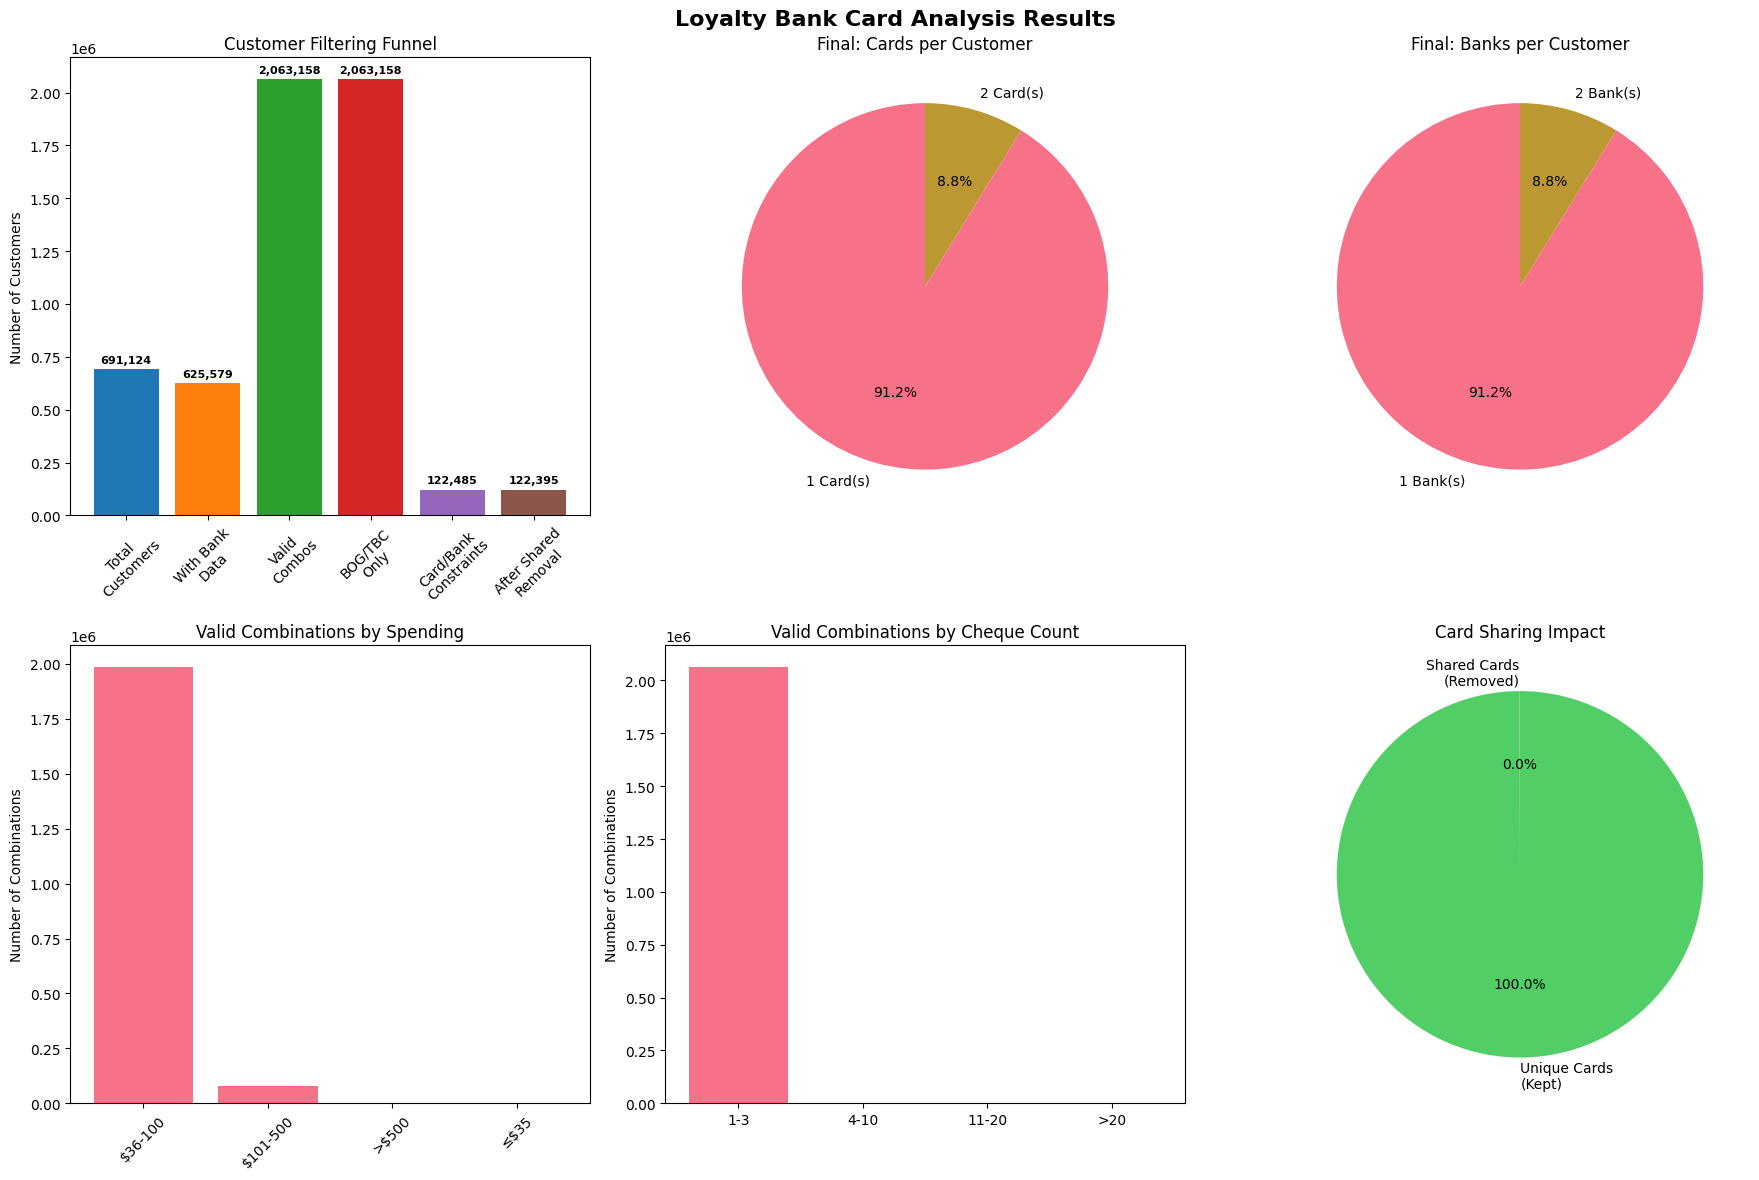


SAVED 5 FILES:
   data\final_clean_customers.csv
   data\final_customer_card_combinations.csv
   data\shared_cards_removed.csv
   data\invalid_customer_card_combinations.csv
   data\analysis_summary.csv

MAIN OUTPUT FILE: data\final_clean_customers.csv
   Customers: 122,395
   Columns: ['customer_id', 'final_cards_count', 'different_banks_count', 'total_cheques', 'total_spending', 'final_cards_list_str', 'different_banks_list_str', 'clients_list_str']
   Distribution: 111,638 customers with 1 card, 10,757 customers with 2 cards

ANALYSIS COMPLETED SUCCESSFULLY!


In [36]:
results, summary = run_complete_analysis_with_validation()